In [153]:
# Author: Uzodimma E. Igodo
# Date: 2023-07-13
# Description: This code implements Regression Machine Learning Models and it was written with a low-level tool for linear algebra (numpy)

# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import one dataset for linear regression and another one for binary classification
from sklearn.datasets import load_breast_cancer, fetch_california_housing

In [154]:
class Regression_Model:
    def __init__(self, X, y, X_val, y_val, model, lambdas = 0):
        # ensure that input data is of shape = (number of e.g, number of features)
        #pad dataset with ones to enable vectorized implementations, since weights include bias
        #ensure that target vector is two dimentional 
        assert len(X.shape) == 2
        num_features = X.shape[1]
        self.M_train = X.shape[0]
        self.train_input = X
        pad_train = np.ones((self.M_train,1), dtype = np.float32)
        self.train_input = np.concatenate((self.train_input, pad_train), axis = 1)
        self.train_output = y.reshape(-1,1)
        
        assert len(X_val.shape) == 2
        self.M_val = X_val.shape[0]
        self.val_input = X_val
        pad_val = np.ones((self.M_val,1), dtype = np.float32)
        self.val_input = np.concatenate((self.val_input, pad_val), axis = 1)
        self.val_output = y_val.reshape(-1,1)
        
        # initialize weights and biases to a single zero weight vector to ensble vectorized implementation. 
        self.W = np.zeros((num_features + 1, 1), dtype = np.float32)
        
        # use mean square error as loss fucntion and mean absolute error as evaluation metric for linear model
        # use binary crossentropy as loss fucntion in logistic model and binary accuracy as evaluation metric
        self.model = model
        if model == 'linear':
            self.loss_fn = 'mse_loss'
            self.metric = 'MAE'
        elif model == 'logistic':
            self.loss_fn = 'log_loss'
            self.metric = 'Accuracy'
        
        # dictionary to store updated losses and metrics during model training
        self.history = dict()
        
        # hyperparamter to control degree of weight decay
        self.lambdas = lambdas

    # define method for forward propagation
    # use sigmoid activation in logistic model
    def train_forward(self):
        if self.model == 'logistic':
            return sigmoid(self.train_input @ self.W)
        elif self.model == 'linear':
            return self.train_input @ self.W
    
    def val_forward(self):
        if self.model == 'logistic':
            return sigmoid(self.val_input @ self.W)
        elif self.model == 'linear':
            return self.val_input @ self.W
        
    # define method for running predictions on model
    def predict(self, input, from_logits = False):
        if input.shape[1] != self.train_input.shape[1]:
            num_points = input.shape[0]
            pad = np.ones((num_points,1), dtype = np.float32)
            input = np.concatenate((input, pad), axis = 1)
            output = input @ self.W
        else:
            output = input @ self.W
        if self.model == 'logistic':
            logits = sigmoid(output)
            output = (logits > 0.5).astype(np.int32)
            if from_logits:
                return logits
            else:
                return output
        elif self.model == 'linear':
            return output
    
    # define method for calculating weight gradients per epoch
    def weight_gradient(self):
        if self.loss_fn == 'mse_loss':
            return (( self.train_input.T) @ (2 * (self.train_forward() - self.train_output)))/self.M_train + (2 * self.lambdas/self.M_train) * self.W
        elif self.loss_fn == 'log_loss':
            return ((self.train_input.T) @ ( self.train_forward() - self.train_output))/self.M_train + (2 * self.lambdas/self.M_train) * self.W
    
    # define optimization objective(loss function) for linear and logistic models
    def train_loss(self):
        if self.loss_fn == 'mse_loss':
            return np.mean((self.train_forward() - self.train_output) ** 2) + (self.lambdas/2 * self.M_train) * np.linalg.norm(self.W, ord=2) ** 2
        elif self.loss_fn == 'log_loss':
            return np.mean(-1 * (( self.train_output * np.log(self.train_forward() )) + ((1 - self.train_output) * np.log((1 - self.train_forward()) )))) + (self.lambdas / 2 * self.M_train) * np.linalg.norm(self.W, ord=2) ** 2
    
    def val_loss(self):
        if self.loss_fn == 'mse_loss':
            return np.mean((self.val_forward() - self.val_output) ** 2)
        elif self.loss_fn == 'log_loss':
            return np.mean((-1 * self.val_output * np.log(self.val_forward())) + ((1 - self.val_output) * np.log((1 - self.val_forward()) ))) + (self.lambdas / 2 * self.M_train) * np.linalg.norm(self.W, ord=2) ** 2
    
    # define method to evaluate model performance 
    def evaluate(self, input, output):
        if self.metric == 'MAE':
            metric = Mean_Absolute_Error(output, self.predict(input))
            return metric
        if self.metric == 'Accuracy':
            metric = np.mean(output == self.predict(input))
            return metric
    
    # define method for updating weights per epoch
    def gradient_descent(self, lr):
        temp_W = self.W - lr * self.weight_gradient()
        self.W = temp_W
    
    # define method for iteratively updating weights and executing gradient descent 
    # optimization algorithm in full
    def fit(self, lr = 0.01, epochs = 1000):
        train_cost = []
        val_cost = []
        train_metric = []
        val_metric = []
        for i in range(epochs):
            self.gradient_descent(lr)
            train_losses = np.round(np.squeeze(self.train_loss()),3)
            train_metrics = np.round(self.evaluate(self.train_input, self.train_output),3)
            val_losses = np.round(np.squeeze(self.val_loss()),3)
            val_metrics = np.round(self.evaluate(self.val_input, self.val_output),3)
            train_cost.append(train_losses)
            val_cost.append(val_losses)
            train_metric.append(train_metrics)
            val_metric.append(val_metrics)
        
            print(f'Epoch-{i}------Train loss:{train_losses}--Train {self.metric}:{train_metrics}----Val loss:{val_losses}--Val {self.metric}:{val_metrics}')
            print()
        self.history['train_loss'] = train_cost
        self.history['val_loss'] = val_cost
        self.history[f'train_{self.metric}'] = train_metric
        self.history[f'val_{self.metric}'] = val_metric
        

    

In [155]:
# define Utility functions 
# more functions may be added in future

def sigmoid(input):
        return 1/(1 + np.exp(-1 * input))  

def Mean_Absolute_Error(output, predict):
        assert len(output.shape) == 2
        assert len(predict.shape) == 2
        error = predict - output
        abs_error = np.abs(error)
        mae = np.mean(abs_error)
        return mae
    
def plot_learning_curves(log):
    fig, ax = plt.subplots(2,1, sharex = True, figsize = (5,10))
    ax[0].plot(log.index, log.iloc[:,0], label = 'Train')
    ax[0].plot(log.index, log.iloc[:,1], label = 'Val')
    ax[1].plot(log.index, log.iloc[:,2], label = 'Train')
    ax[1].plot(log.index, log.iloc[:,3], label = 'Val')
    ax[0].set_title(f'{log.columns[0]} vs {log.columns[1]}')
    ax[1].set_title(f'{log.columns[2]} vs {log.columns[3]}')
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Metric')
    ax[1].set_xlabel('Epochs')
    ax[0].legend()
    ax[1].legend()
    plt.show() 
        

In [156]:
# load classification dataset
data1 = load_breast_cancer()
labels1 = data1.target_names

input1 = pd.DataFrame(data = data1.data, columns = data1.feature_names)
output1 = pd.Series(data = data1.target).to_frame()

# standardize and scale feature to accelerate learning and improve model performance
input1 = (input1 - input1.mean(axis = 0))/ input1.std(axis = 0)

# split dataset into train, validation and test sets
X1, X_val1, y1, y_val1 = train_test_split(input1.values, output1.values, test_size = 0.30, random_state = 0)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_val1, y_val1, test_size = 0.20, random_state = 2)


# load linear regression dataset
data2 = fetch_california_housing()
labels2 = data2.target_names

input2 = pd.DataFrame(data = data2.data, columns = data2.feature_names)
output2 = pd.Series(data = data2.target).to_frame()

input2 = (input2 - input2.mean(axis = 0))/ input2.std(axis = 0)

X2, X_val2, y2, y_val2 = train_test_split(input2.values, output2.values, test_size = 0.30, random_state = 0)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_val2, y_val2, test_size = 0.20, random_state = 2)

In [167]:
# load logistic regression model and dsiplay performance on test dataset before training
model1 = Regression_Model(X1, y1, X_val1, y_val1, 'logistic')

metric_before_train1 = model1.evaluate(X_test1, y_test1)
print(f'Accuracy before training : {metric_before_train1}')

Accuracy before training : 0.2857142857142857


In [168]:
# load linear regression model and get performance metric before training
model2 = Regression_Model(X2, y2, X_val2, y_val2, 'linear')

metric_before_train2 = model2.evaluate(X_test2, y_test2)
print(f'Mean absolute error before training : {metric_before_train2}')

Mean absolute error before training : 2.1116808635996773


In [169]:
# call fit method on model to commence training
model1.fit()



Epoch-0------Train loss:0.673--Train Accuracy:0.955----Val loss:0.152--Val Accuracy:0.89

Epoch-1------Train loss:0.654--Train Accuracy:0.955----Val loss:0.151--Val Accuracy:0.89

Epoch-2------Train loss:0.637--Train Accuracy:0.955----Val loss:0.15--Val Accuracy:0.89

Epoch-3------Train loss:0.62--Train Accuracy:0.955----Val loss:0.149--Val Accuracy:0.897

Epoch-4------Train loss:0.605--Train Accuracy:0.955----Val loss:0.148--Val Accuracy:0.897

Epoch-5------Train loss:0.591--Train Accuracy:0.955----Val loss:0.146--Val Accuracy:0.897

Epoch-6------Train loss:0.577--Train Accuracy:0.955----Val loss:0.145--Val Accuracy:0.897

Epoch-7------Train loss:0.564--Train Accuracy:0.955----Val loss:0.144--Val Accuracy:0.897

Epoch-8------Train loss:0.552--Train Accuracy:0.955----Val loss:0.142--Val Accuracy:0.904

Epoch-9------Train loss:0.54--Train Accuracy:0.955----Val loss:0.141--Val Accuracy:0.904

Epoch-10------Train loss:0.53--Train Accuracy:0.955----Val loss:0.14--Val Accuracy:0.904

Epoch-

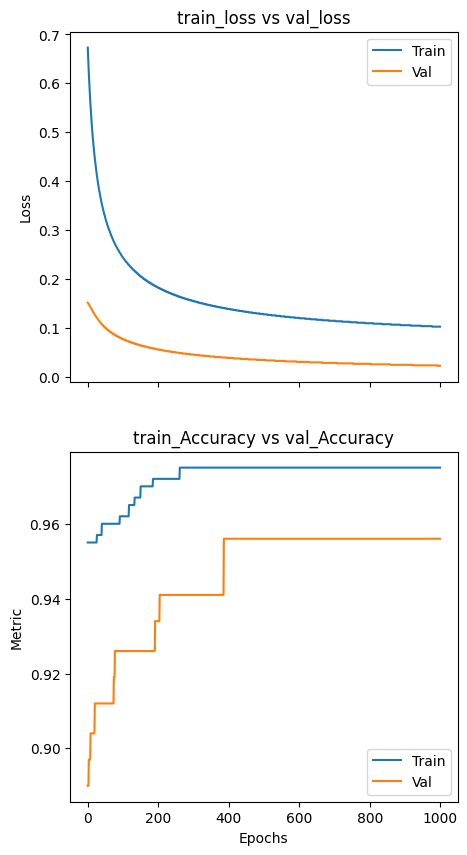

In [170]:
# load training log details into dataframe to monitor model training and plot learning curves
log1 = pd.DataFrame(data = model1.history)
plot_learning_curves(log1)

In [171]:
model2.fit()


Epoch-0------Train loss:5.411--Train MAE:2.027----Val loss:5.364--Val MAE:2.017

Epoch-1------Train loss:5.222--Train MAE:1.986----Val loss:5.176--Val MAE:1.977

Epoch-2------Train loss:5.04--Train MAE:1.947----Val loss:4.995--Val MAE:1.937

Epoch-3------Train loss:4.865--Train MAE:1.908----Val loss:4.822--Val MAE:1.898

Epoch-4------Train loss:4.698--Train MAE:1.87----Val loss:4.655--Val MAE:1.86

Epoch-5------Train loss:4.537--Train MAE:1.832----Val loss:4.495--Val MAE:1.823

Epoch-6------Train loss:4.382--Train MAE:1.796----Val loss:4.342--Val MAE:1.786

Epoch-7------Train loss:4.234--Train MAE:1.76----Val loss:4.194--Val MAE:1.75

Epoch-8------Train loss:4.091--Train MAE:1.725----Val loss:4.053--Val MAE:1.715

Epoch-9------Train loss:3.954--Train MAE:1.69----Val loss:3.917--Val MAE:1.68

Epoch-10------Train loss:3.823--Train MAE:1.657----Val loss:3.787--Val MAE:1.647

Epoch-11------Train loss:3.697--Train MAE:1.623----Val loss:3.662--Val MAE:1.614

Epoch-12------Train loss:3.575--T

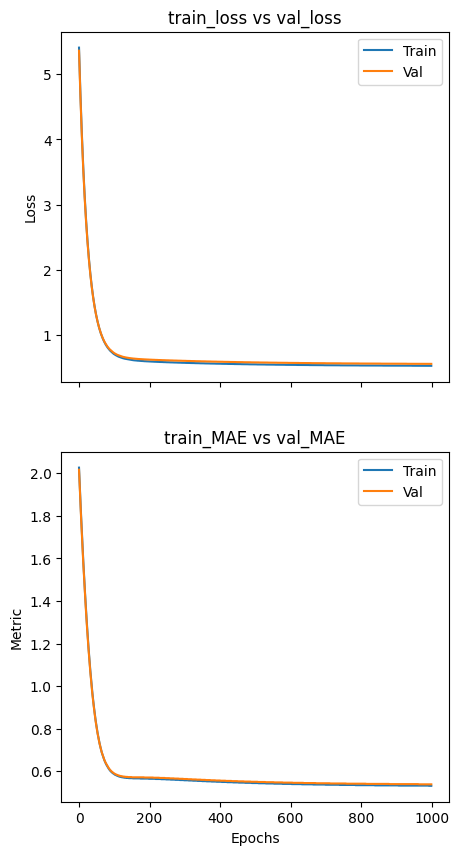

In [172]:
log2 = pd.DataFrame(data = model2.history)
plot_learning_curves(log2)

In [173]:
# Note that accuracy  is expected to INCREASE for logistic model and MAE is expected to DECREASE for linear model
# Accuracy ranges 0 to 1 and MAE ranges 0 to initinity

In [174]:
# display model performance on test dataset after training
metric_after_train1 = model1.evaluate(X_test1, y_test1)
print(f'Accuracy after training : {metric_after_train1}')

Accuracy after training : 1.0


In [175]:
metric_after_train2 = model2.evaluate(X_test2, y_test2)
print(f'Mean absolute error after training : {metric_after_train2}')

Mean absolute error after training : 0.5405167648328115
